### 0. **라이브러리 import**

In [1]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### 1. **이미지 불러오기**:
   - `Image.open(image_path)`를 사용하여 로컬 파일 시스템에서 이미지를 불러옵니다. `image_path` 변수에 이미지 파일의 경로를 지정합니다.


In [2]:
# 로컬 파일 시스템에서 이미지를 불러오기
image_path = "sample_photo.JPG"  # 이미지 경로를 지정
image = Image.open(image_path)


### 2. **모델 로드**:
   - `torch.hub.load`를 사용하여 사전 훈련된 DeepLabV3 모델을 로드합니다. 모델을 평가 모드로 전환합니다(`model.eval()`).


In [3]:
# DeepLabV3 모델을 로드
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()  # 모델을 평가 모드로 전환

Using cache found in /Users/seungwoopark/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se


### 3. **입력 이미지 전처리**:
   - 이미지를 텐서로 변환하고, 모델에 필요한 정규화 과정을 수행합니다.
   - `input_tensor.unsqueeze(0)`를 사용하여 배치 차원을 추가합니다.


In [4]:
# 입력 이미지를 전처리
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # batch 차원 추가

### 4. **GPU 사용**:
   - GPU가 사용 가능한 경우, 모델과 데이터를 GPU로 이동합니다.


In [5]:
# GPU가 사용 가능하면 모델과 데이터를 GPU로 이동
if torch.cuda.is_available():
    model.to('cuda')
    input_batch = input_batch.to('cuda')


### 5. **예측 수행**:
   - `with torch.no_grad()` 블록 내에서 예측을 수행하여 그래디언트 계산을 비활성화합니다.
   - `output.argmax(0)`를 사용하여 예측된 클래스 맵을 얻습니다.


In [6]:
# 예측 수행
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)


### 6. **사람 영역 마스킹**:
   - 사람 클래스 인덱스(15)를 사용하여 사람 영역을 마스킹합니다.


In [7]:
# 사람이 포함된 영역만 마스크로 표시
person_class = 15  # 사람 클래스 인덱스 (DeepLabV3 기준)
mask = output_predictions == person_class

# 원본 이미지를 NumPy 배열로 변환
image_np = np.array(image)

# 사람 영역을 빨간색으로 표시
image_np[mask.cpu().numpy()] = [255, 0, 0]


### 7. **결과 시각화**:
   - 원본 이미지와 분할된 이미지를 나란히 표시하여 비교합니다.
   - 사람 영역을 빨간색으로 표시하여 분할 결과를 시각화합니다.


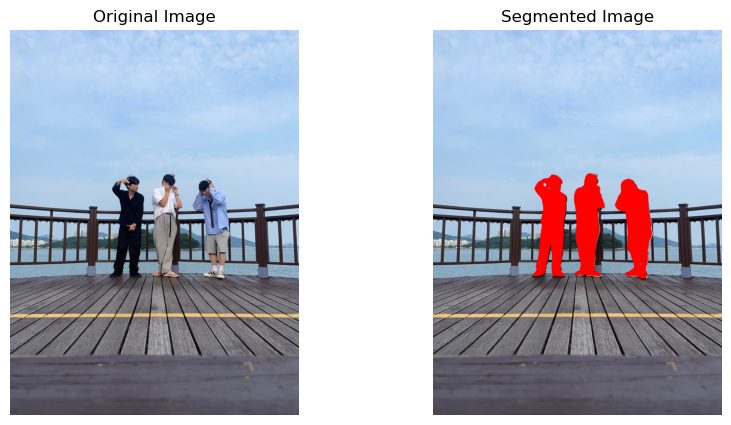

In [8]:
# 결과 이미지 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented Image")
plt.imshow(image_np)
plt.axis('off')

plt.show()